## Prelimiary Operations

### Manage the directories

In [46]:
# Not important
import os
os.listdir("../input/an2dlhw1bal-dataset/splitted_dataset")

['val', 'test', 'train']

In [47]:
# To delete a folder
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [48]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [49]:
# to create a folder
import os
directory = "VGG16"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [51]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [52]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [53]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [54]:
# Dataset folders 
dataset_dir = '../input/splitted-dataset-no-test/splitted_dataset_no_test'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [55]:
img_height = 96
img_width =96
batch_size = 32

In [56]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

# No test set. Test is performed on the online dataset, to have more images for training

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation

# No rescaling. Use this for data augmentation
train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        shear_range=0.2,
                                        fill_mode='reflect')

# No rescaling. Use this to not perform data augmentation
#train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


## Model

In [57]:
!cd /kaggle/working/VGG16

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

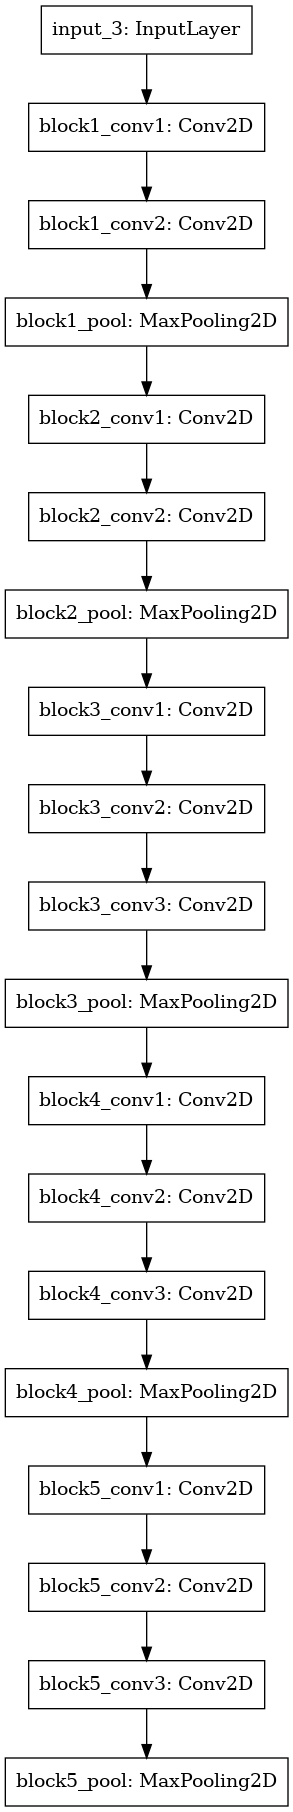

In [58]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [59]:
# Define parameters for training
input_shape = (96, 96, 3)
epochs = 200
l1=0
l2=0
learning_rate = 1e-4

In [60]:
# Re-load the model after transfer learning
# tl_model = tfk.models.load_model('/kaggle/input/vgg-fine-tuned/VGG16FineTuning')
# tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               262656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
classifier2 (Dense)          (None, 64)                32832 

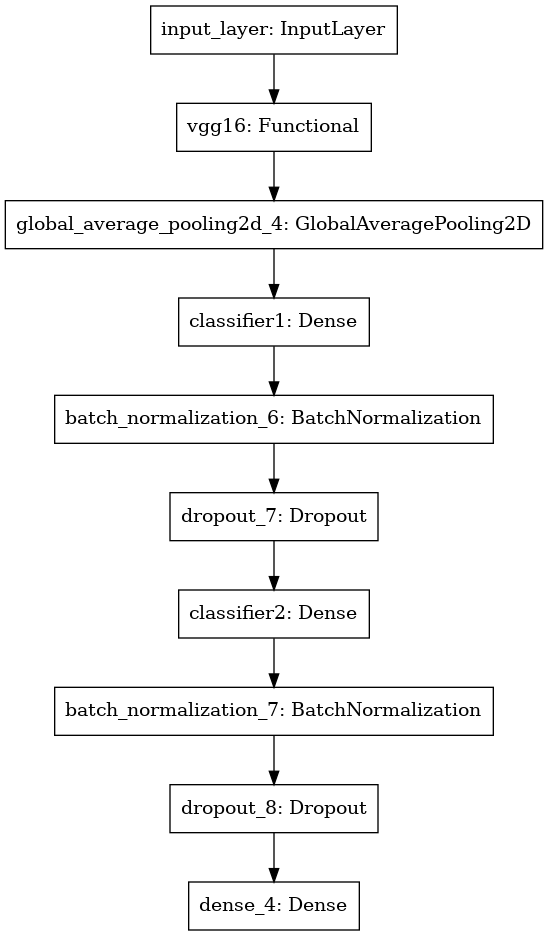

In [61]:
###### Use this if no network saved
from tensorflow.python.framework.tensor_util import GetNumpyAppendFn

# Use the supernet as feature extractor
supernet.trainable = False
# in this way we keep the weights of the CNN part and we will train only the weights of the classifier

input_layer = tfkl.Input(shape=input_shape, name='input_layer')
x = supernet(input_layer)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(units=512, name='classifier1', 
               kernel_initializer=tfk.initializers.HeUniform(seed),
               activation='relu',
               kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(units=64, name='classifier2', 
               kernel_initializer=tfk.initializers.HeUniform(seed),
               activation='relu',
               kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')

# Compile the model
tl_model.summary()
tfk.utils.plot_model(tl_model)

In [62]:
tl_model.get_layer('vgg16').trainable = True

In [63]:
# Freeze first N layers
N = 10

for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
classifier1 (Dense)          (None, 512)               262656    
__

In [64]:
# Compile the model. Here we use RMSProp instead of Adam
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate), metrics='accuracy')

## Training

In [65]:
patience = 20

In [67]:
# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 500,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/500
429/429 [==============================] - 16s 36ms/step - loss: 1.1155 - accuracy: 0.5941 - val_loss: 4.0311 - val_accuracy: 0.5428
Epoch 2/500
429/429 [==============================] - 15s 35ms/step - loss: 1.1285 - accuracy: 0.5967 - val_loss: 1.2106 - val_accuracy: 0.6053
Epoch 3/500
429/429 [==============================] - 16s 36ms/step - loss: 1.1022 - accuracy: 0.5979 - val_loss: 1.4678 - val_accuracy: 0.5127
Epoch 4/500
429/429 [==============================] - 15s 35ms/step - loss: 1.0831 - accuracy: 0.6206 - val_loss: 1.1069 - val_accuracy: 0.6065
Epoch 5/500
429/429 [==============================] - 15s 36ms/step - loss: 1.0475 - accuracy: 0.6311 - val_loss: 1.3205 - val_accuracy: 0.5833
Epoch 6/500
429/429 [==============================] - 15s 36ms/step - loss: 1.0037 - accuracy: 0.6416 - val_loss: 1.2960 - val_accuracy: 0.6100
Epoch 7/500
429/429 [==============================] - 16s 37ms/step - loss: 0.9714 - accuracy: 0.6573 - val_loss: 1.7094 - val_ac

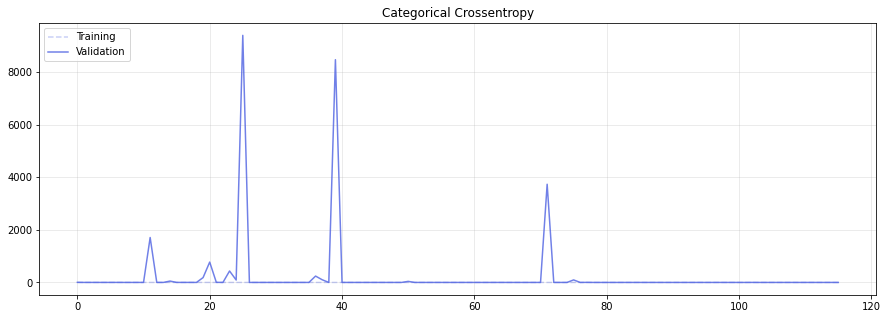

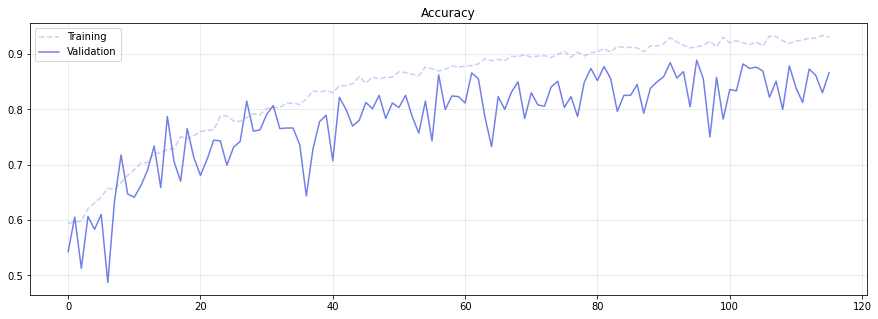

In [68]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Training', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig("VGG16_fine_tuning_loss.png")

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], label='Training',alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig("VGG16_fine_tuning_acc.png")

plt.show()

In [69]:
# Save the best model
tl_model.save('VGG16_fine_tuning')
#del tl_model

2022-11-18 12:21:56.536428: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [70]:
# Evaluate on val
val_metrics = tl_model.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

108/108 [==============================] - 1s 11ms/step - loss: 0.3811 - accuracy: 0.8889

Val metrics
{'loss': 0.38109391927719116, 'accuracy': 0.8888888955116272}


In [71]:
import shutil
shutil.make_archive("VGG16FineTuning", 'zip', "/kaggle/working/VGG16_fine_tuning/")

'/kaggle/working/VGG16FineTuning.zip'